### Importing Libraries and Mounting GDrive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

datadir = '/content/drive/MyDrive/Personal Projects/Asteroid Classification/Data/nasa.csv'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### EDA & Feature Engineering
___
The data we will be using throughout this notebook comes from <a href="https://cneos.jpl.nasa.gov/">JPL's</a> official open source website. It contains morphological information of asteroids. The data was collected using NeoWs (Near Earth Object Web Service) which is a RESTful web service for near earth Asteroid information. With NeoWs a user can: search for Asteroids based on their closest approach date to Earth, lookup a specific Asteroid with its NASA JPL small body id, as well as browse the overall data-set.

The raw data itself contains 40 columns which we will describe below:

* `Neo Reference ID` - unique reference ID of Neo.
* `Name` - catalog name.
* `Absolute Magnitude` - In astronomy, the absolute magnitude of a star is defined as the brighness of a star observed from standard distance of 10 parsecs. The same applies to any celestial objects. Invented in 150 B.C by Hipparcus, the higher the value the dimmer it is and vice versa. This value along with the apparent magnitude (brightness of an object as seen from earth) allows us to estimate its distance relative to Earth.
* `Est Dia in unit(min)` and `Est Dia in unit(max)` - There are 8 columns containing the same information in different units (Kilometer, Meter, Miles, Feet). This is the estimated min and max diameter of the object.
* `Close Approac Date` - in Epoch and calendar year.
* `Relative Velocity` - in km/s and km/hr.
* `velocity` - in mph. This is the velocity of the object relative to its own frame of reference (i.e. standing on the asteroid itself).
* `Miss Dist.` - closest approach distance in AU, Km, and Miles.
* The rest of the columns, except the last one, provide information about its orbit.
* `Hazardous` - Wheter or not the asteroid represents a significant threat to earth.


In [3]:
# Loading the data from GDrive
df = pd.read_csv(datadir)
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


Based on the description of the features in the dataset, we can begin to discard some of those features. `Reference ID`, `Name` and `oribit id` provide no real value to our statistical analysis are they are unique values added to identify a given asteroid. The `Close Approac Date` and `Orbit determination Date` will also provide no value to our analysis since we're not doing a time series analysis. Lastly we have some features have the same value for all of our entries such as `Orbitting Body`:= 'Earth' and `Equinox`:='J2000'.

There are other significant features in our data that we want to keep but we have redundant copies of it. The `Est Dia in UNITS(min/max)` contains the estimated diamter of the asteroind in Kilometers, feet, meters and miles. In physics we often work with SI or CGS (centimeter gram seconds) units with the latter been more appropiate for smaller scales such as quantum mechanic scales. For this problem we'll stick to Km and remove the rest.

In [4]:
removed_features = [
    'Neo Reference ID', 'Name', 'Orbiting Body', 'Orbit ID','Orbiting Body',
    'Orbit Determination Date', 'Epoch Date Close Approach', 'Equinox', 
    'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)',
    'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)',
    'Relative Velocity km per hr', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
    'Miss Dist.(miles)', 'Perihelion Time', 'Close Approach Date'
]
df = df.drop(columns=removed_features)

**In order to maintain consistency, we have to chance the `Miles per hour` feature since we have been working with SI units.** To do this, we note that:

<center> 1 mile = 1.60934 Km   and   1 hour = 3600 seconds
<center> $\therefore$ 1 mph = 0.00044704 $\rm \frac{Km}{s}$

In [5]:
df['KM per second'] = df['Miles per hour'] * (0.00044704)
df = df.drop(columns=['Miles per hour'])

**We also note that the `Miss Dist.(kilometers)` has a $10^6$ order of magnitude discrepancy to the other features, so we'll normalize it into a new feature called `Miss Dist. normed` which is Km/$10^6$. This is a convention in physics research as we often find scales that can be quite large, and it helps us stablish better physical relationships.

In [6]:
df['Miss Dist. normed'] = df['Miss Dist.(kilometers)'] * 1e-6
df = df.drop(columns=['Miss Dist.(kilometers)'])

**Lets now take a look at how the remaing features relate to each other by using a correlation matrix**

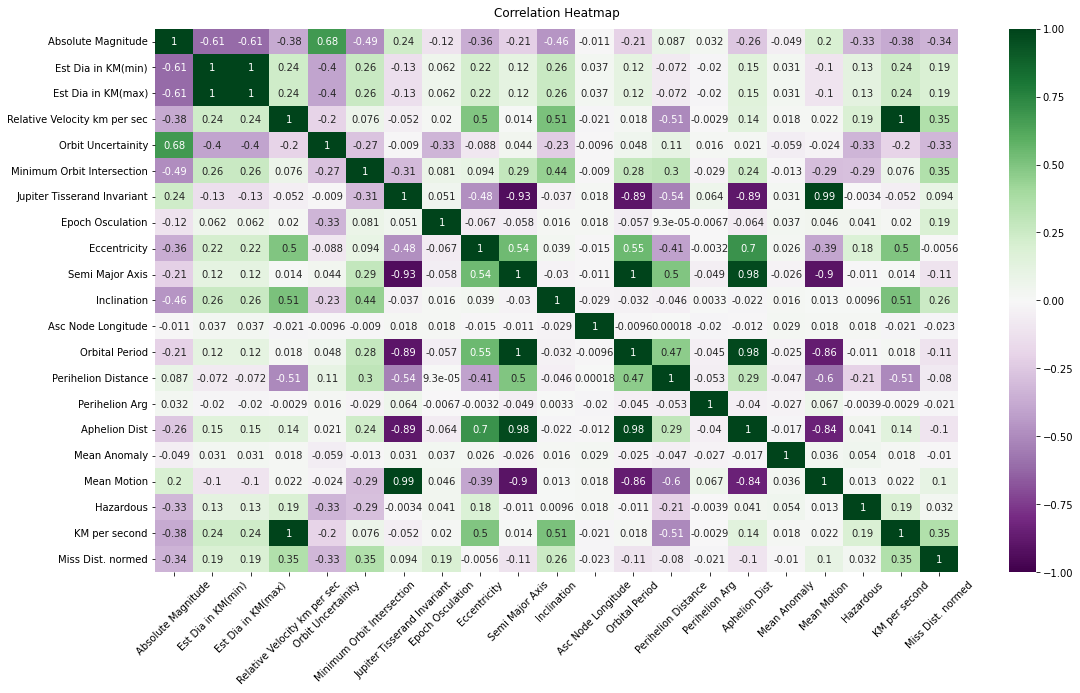

In [9]:
plt.figure(figsize=(18, 10))

heatmap = sb.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='PRGn')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

**We can see that there's a strong correlation between `Est Diam in HM(min)` and `Est Diam in HM(max)` which is intuitive as they are part of a confidence interval to estimate the same value. Instead of removing one of the features, we'll take the average of both and remove the min and max.** We also make an important note about the strong correlation between `relative velocity` and `KM per second`, since relative velocity can be derived from non relative velocity by changing our frame of reference, it makes sense that they are related. To deal with this, we'll generalize and work from *Earths* frame of reference, therefore we can remove the `KM per second` feature.

In [10]:
df['Est Dia in KM'] = (df['Est Dia in KM(min)'] + df['Est Dia in KM(max)']) / 2
df = df.drop(columns=['Est Dia in KM(min)', 'Est Dia in KM(max)', 'KM per second'])

If we take a look at the correlation between the `Semi Major Axis` and `Orbital Period` we see that there's a strong correlation. We can further take a look at a scatter of plot of the two.

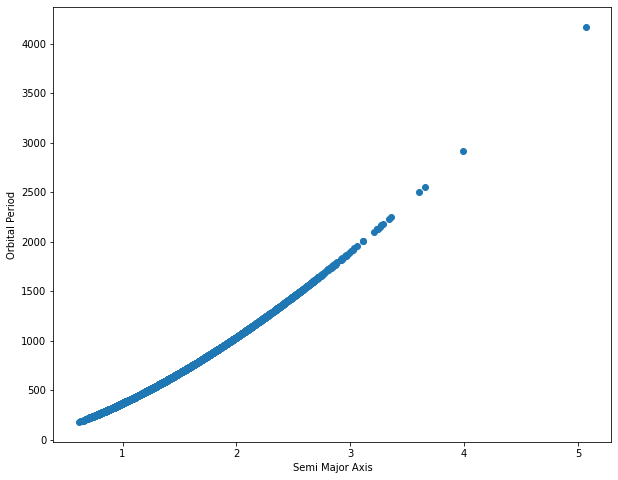

In [11]:
plt.figure(figsize=(10, 8))

plt.scatter(df['Semi Major Axis'], df['Orbital Period'])
plt.xlabel('Semi Major Axis')
plt.ylabel('Orbital Period');

We can confirm this relationship by invoking Kepplers third law (KIII) of Kepplerian orbits:

$$ P^2 = \frac{4 \pi^2}{G M} a^3$$

Where *P* is the orbital period of a body, *G* the gravitational constant and *a* the semi major axis. To stay consistent with the order of magnitudes of our units, we'll get rid of the period. We note that since we have both values, we can create a new feature to estimate the mass of the asteroid since $M$ is already embedded in this relationship and it represents the mass of the Asteroid-Earth systems.

Furthermore, we can also observe a strong relationship between the `Aphelion Dist` and the `Semi Major Axis` as seen in the scatter plot below.

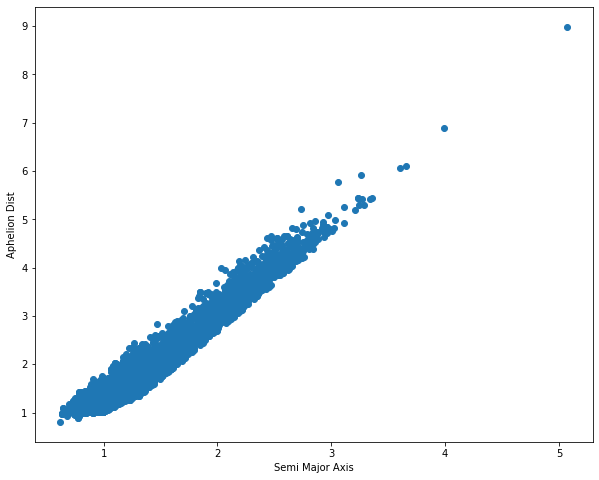

In [12]:
plt.figure(figsize=(10, 8))

plt.scatter(df['Semi Major Axis'], df['Aphelion Dist'])
plt.xlabel('Semi Major Axis')
plt.ylabel('Aphelion Dist');

The Aphelion distance is defined as the furthest distance in an eccentric orbit from the focus point. In our solar system the focus point is near the sun, and in general is the center of mass which is why is not AT the sun. On Earth we reach the aphelion when we are furthest from the sun which usually occcurs around the summer in the central parts of the world. Mathematically, the aphelion distance can be derived from geometric principles of an ellipse, and is defined as:

$$ A = a (1 + e) $$

Where $a$ is the semi-major axis and $e$ is the eccentricity of the ellipse. This is how we can explain the relationship in our dataset.

To maintain our practice of removing redundant data, we see that the `Semi Major Axis` feature is embedded in two relationships, we can then remove the `Orbital Period` and `Apehelion Dist` features as they can be obtained from the first quantity.

In [13]:
df = df.drop(columns = ['Orbital Period', 'Aphelion Dist'])

**Let's now observe what are correlation matrix looks like.**

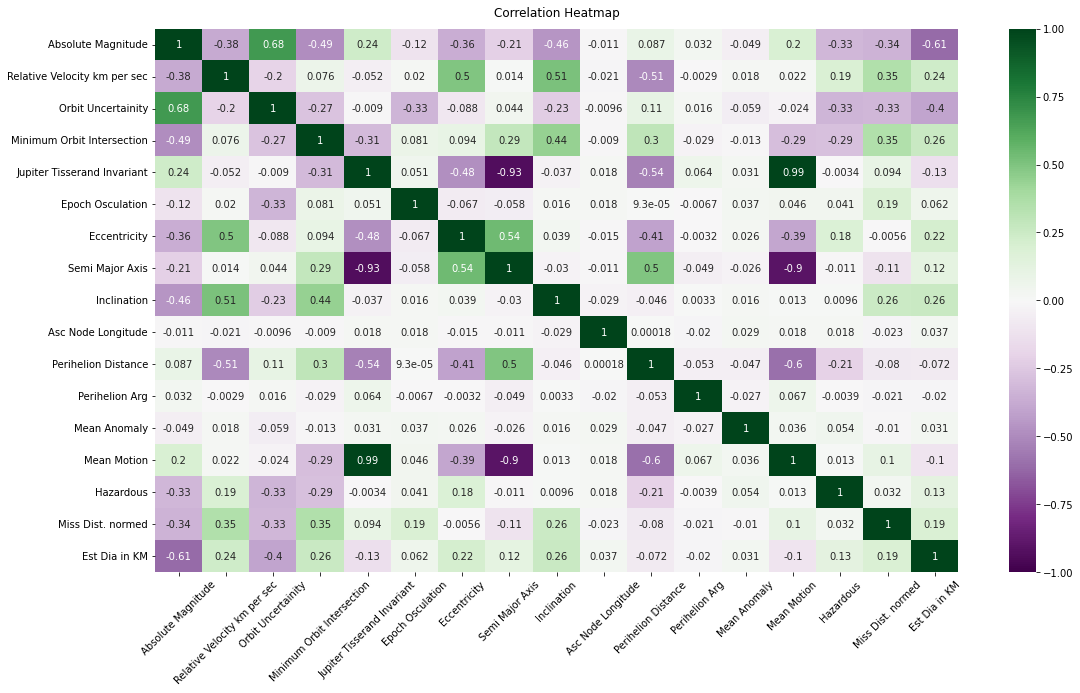

In [14]:
plt.figure(figsize=(18, 10))

heatmap = sb.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='PRGn')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

**We can no proceed with the modeling portion but first, we'll split the data into training and testing.** But first, we note that most of the instances in our dataset belong to the *not Hazardous* class. In fact, over 88% of instances belong to this class, therefore this dataset is **imbalanced** and we should not use accuracy as a metric of performance as our model can already predict all instances as False and achieved over 88% accuracy. Instead, we will use accuracy as a baseline and we will look to improve on it.

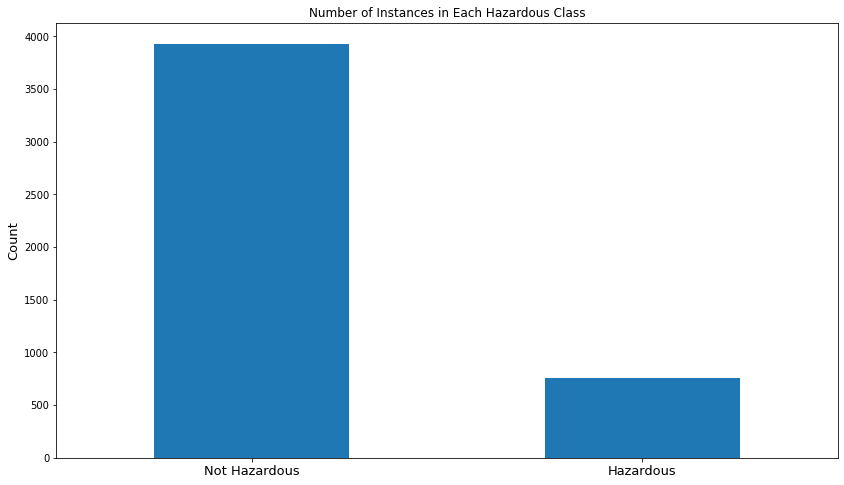

In [15]:
ax = df['Hazardous'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Instances in Each Hazardous Class")
ax.set_ylabel("Count", size=13)
ax.set_xticklabels(['Not Hazardous', 'Hazardous'], rotation=360, size=13);

In [16]:
X = df.drop(columns=['Hazardous'])
Y = df.Hazardous.astype(int)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

### Classification
___

As we had previously discussed, our dataset is imbalanced, and therefore accuracy is not a good metric to determine the "goodness" of our model. When working with an imbalanced dataset, we want to keep in mind what the endgoal is. For instance, if we were working with a dataset that contains instances of cancer test results which are used diagnose patients. We would ideally want our model to predict as high a percentage as possible of cancer cases with few as possible false positives, this means optimizing recall over accuracy or precision is more important.

In our case, we want to create a **robust** model. This means a model that is able to perform well when presented with new data. Therefore, the F1-score may be a more significant metric as it combines both recall and precision in a harmonic mean. A more optimal metric would be the **Mathews Correlation Coefficient (MCC)** which is mathematically defined as:

$$ MCC = \frac{TP\cdot TN + FP\cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}} $$

The MCC is not a biased metric and it allows for flexibility when working with unbalanced data. MCC returns a value between -1 and 1 where -1 implies a disagrement between predictions and observation, 0 represents no better than random prediction and 1 a perfect prediction. We will use both F1-score and MCC as metric for our models.

In [18]:
from sklearn.metrics import confusion_matrix

def get_metrics(FP, FN, TP, TN):
  accuracy = (TN + TP) / (TP + TN + FP + FN)
  specificity = TN / (TN + FP)
  recall = TP / (FN + TP)
  precision = TP / (TP + FP)
  F1score = 2 * (recall * precision) / (recall + precision)
  MCC = (TP*TN - FP*FN) / np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)) # Mathews Correlation Coefficient
  metrics = {
      'accuracy' : accuracy,
      'specificity': specificity,
      'F1score'  : F1score,
      'MCC'      : MCC
  }
  return metrics

def print_metrics(ypredTrain=None, ytrueTrain=y_train, 
                  ypredTest=None, ytrueTest=y_test):
  
  cmtrain = confusion_matrix(ytrueTrain, ypredTrain)
  cmtest = confusion_matrix(ypredTest, ytrueTest)
  
  trainmetrics = get_metrics(cmtrain[0, 1], cmtrain[1, 0],
                             cmtrain[1, 1], cmtrain[0, 0])
  testmetrics = get_metrics(cmtest[0, 1], cmtest[1, 0],
                             cmtest[1, 1], cmtest[0, 0])


  print('Metric\t   | Value  | Dataset')
  print('_____________________________')
  print('Accuracy   | %.4f | train' % trainmetrics['accuracy'])
  print('Specificity| %.4f | train' % trainmetrics['specificity'])
  print('F1-Score   | %.4f | train' % trainmetrics['F1score'])
  print('MCC\t   | %.4f | train' % trainmetrics['MCC'])
  print('_____________________________')
  print('Accuracy   | %.4f | test' % testmetrics['accuracy'])
  print('Specificity| %.4f | test' % testmetrics['specificity'])
  print('F1-Score   | %.4f | test' % testmetrics['F1score'])
  print('MCC\t   | %.4f | test' % testmetrics['MCC'])

We will use the following 3 models for our prediction:

* Decision Tree
* Naive Bayes
* Random Forest

We will then choose the highest performing model to optimize.

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
nb = GaussianNB()
nb.fit(X_train, y_train)
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

In [20]:
print_metrics(ypredTrain=dt.predict(X_train), ypredTest=dt.predict(X_test))

Metric	   | Value  | Dataset
_____________________________
Accuracy   | 1.0000 | train
Specificity| 1.0000 | train
F1-Score   | 1.0000 | train
MCC	   | 1.0000 | train
_____________________________
Accuracy   | 0.9840 | test
Specificity| 0.9897 | test
F1-Score   | 0.9547 | test
MCC	   | 0.9450 | test


In [21]:
print_metrics(ypredTrain=nb.predict(X_train), ypredTest=nb.predict(X_test))

Metric	   | Value  | Dataset
_____________________________
Accuracy   | 0.9090 | train
Specificity| 0.9263 | train
F1-Score   | 0.7383 | train
MCC	   | 0.6885 | train
_____________________________
Accuracy   | 0.8977 | test
Specificity| 0.9568 | test
F1-Score   | 0.7363 | test
MCC	   | 0.6774 | test


In [22]:
print_metrics(ypredTrain=rf.predict(X_train), ypredTest=rf.predict(X_test))

Metric	   | Value  | Dataset
_____________________________
Accuracy   | 1.0000 | train
Specificity| 1.0000 | train
F1-Score   | 1.0000 | train
MCC	   | 1.0000 | train
_____________________________
Accuracy   | 0.9904 | test
Specificity| 0.9897 | test
F1-Score   | 0.9723 | test
MCC	   | 0.9668 | test


Based on the results of our models, it seems that the Naive Bayes classifier did a poor job during training and testing. Achieving an accuracy of about 90% one may think that we improved on the baseline, but analyizing the F1-score and the MCC, for both the training and test set, we noticed that it did worst than the baseline. On the other hand, both the decision tree and random forest classifier outperformed the baseline and since we reached an MCC score close to 1.0, we can conclude that they both did a great job with predicing unseen data. Since both models have achieved really high metrics, we can argue that there's no need to optimize the models. In practice, we would ideally spend a significant amount of time optimizing the models but we should be able to argue that the amount of time justifies the increase on performance. In our case, we could increase the MCC and F1-score but there's no significant trade of.